In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)
    

# Define the log-normal function
def log_normal(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [3]:
def get_mass_functions(simulation, snapshot=127, subdir='/output/', age_young = 1., age_intermediate=6., age_old=10., inner_radius=0., outer_radius=None,\
                       low_mass_cut=None, high_mass_cut=None, decomposition=None, plot_agedistribution=False, plot_decomposition=False):
    print('Loading simulation: '+simulation)
    sf = load_subfind(snapshot, dir=simulation+subdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=simulation+subdir, subfind=sf, hdf5=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    galrad = sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    if outer_radius is None:
        outer_radius = 1e3*galrad

    print('Stellar mass of the galaxy: {:2.2e} Msun'.format(1e10*sf.data['smty'][0, 4]))

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    starparts = (s.data['age']>0.) * (s.r() <= galrad) * (s.data['subhalo']==0)
    mask_clusters_initial = (s.data['incl'][starparts] > 0 ) * (1e3*s.r()[starparts] > inner_radius) * (1e3*s.r()[starparts] <= outer_radius)
    
    Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)
    jz = Lz[starparts]
    ii = np.argsort(orbital_energy[starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1


    if decomposition is None:
        mask_decomposition = np.ones_like(eps[mask_clusters_initial], dtype=bool)
    else:
        # Build feature array: [ε, Energy]
        X = np.vstack((eps,orbital_energy[starparts],
                        np.log10(np.abs(s.data['pos'][:,0][starparts])))).T

        # Fit GMM
        gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts]), -2.0],
                                                        [0.9,np.median(orbital_energy[starparts]), -5.0]],
                                                        covariance_type='full', random_state=42)
        gmm.fit(X)

        # Predict cluster memberships
        decomp_labels = gmm.predict(X)
        median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
        sph_label = np.argmin(np.array(median_eps))
        disc_label = np.argmax(np.array(median_eps))

        # Force assign disc_label to clusters with high circularity parameter
        mask = (decomp_labels == sph_label) & (eps > 0.7)# & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.5))
        decomp_labels[mask] = disc_label

        # Force assign sph_label to clusters with high z-coordinate (10kpc)
        mask = (decomp_labels == disc_label) & (np.abs(s.data['pos'][:,0][starparts])*1e3 > 5.)
        decomp_labels[mask] = sph_label
        
        if decomposition == 'Spheroid':
            print('GMM Label for Spheroid:', sph_label)
            mask_decomposition = decomp_labels[mask_clusters_initial] == sph_label
        elif decomposition == 'Disc':
            print('GMM Label for Disc:', disc_label)
            mask_decomposition = decomp_labels[mask_clusters_initial] == disc_label

        if plot_decomposition:
            label_color = plt.cm.viridis(np.linspace(0, 1, 2))
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].scatter(eps, orbital_energy[starparts],
                        c=decomp_labels, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
            ax[0].set(xlabel='Circularity ε', ylabel='Energy', xlim=(-2,2))

            ax[1].hist(eps, histtype='step', bins=20, range=[-1.5,1.5], label='Stars with SCs')
            for i in range(gmm.n_components):
                ax[1].hist(eps[(decomp_labels==i)], histtype='step', edgecolor=label_color[i], bins=20, range=[-1.5,1.5], label=f'Component {i}')
            ax[1].get_yaxis().set_ticks([])
            ax[1].legend(loc='upper left')
            ax[1].set_xlabel('Circularity ε')
            plt.show()
    
    cluster_masses = s.data['mclt'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    print('Maximum initial number of clusters per star {:d}'.format(s.data['incl'].max()))
    print('Maximum initial mass {:2.2e} Msun'.format(1e10*init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(1e10*cluster_masses.max()))

    clusters_formtime = np.repeat(s.data['age'][starparts][mask_clusters_initial][mask_decomposition], s.data['incl'][starparts][mask_clusters_initial][mask_decomposition])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

    mask_problematic = s.data['imfc'][starparts][mask_clusters_initial][mask_decomposition]>1.
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][starparts][mask_clusters_initial][mask_decomposition]) * 100))

    if low_mass_cut is None:
        low_mass_cut = 1e2
    if high_mass_cut is None:
        high_mass_cut = 1e8
    
    not_empty_clusters = (cluster_masses>0.)
    init_mass_cut = (1e10*init_cluster_masses[not_empty_clusters]>low_mass_cut) * (1e10*init_cluster_masses[not_empty_clusters]<high_mass_cut)
    
    if plot_agedistribution:
        plt.hist(clusters_age[not_empty_clusters][init_mass_cut], bins=20, histtype='step', density=True)
        plt.xlabel('Cluster`s age [Gyr]')
        plt.ylabel('Age Distribution')
        plt.title(simulation)
        plt.show()
    
    young_mask = (clusters_age[not_empty_clusters][init_mass_cut]<age_young)
    intemediate_mask = (clusters_age[not_empty_clusters][init_mass_cut]>age_intermediate)
    old_mask = (clusters_age[not_empty_clusters][init_mass_cut]>age_old)

    nbins = 25
    min_gcmf = 1e2 # in solar masses
    min_icmf = 5e3 # in solar masses
    max_gcmf = 1e8 # in solar masses
    marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
    marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
    width_gcmf = np.diff(marray_gcmf)
    width_icmf = np.diff(marray_icmf)

    init_mass_mask = (1e10*init_cluster_masses>low_mass_cut) * (1e10*init_cluster_masses<high_mass_cut)
    N,_ = np.histogram(np.log10(1e10*init_cluster_masses[init_mass_mask]), bins=marray_icmf)
    initial_population = N/width_icmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut]), bins=marray_gcmf)
    full_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][young_mask]), bins=marray_gcmf)
    young_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][intemediate_mask]), bins=marray_gcmf)
    intermediate_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][old_mask]), bins=marray_gcmf)
    old_population = N/width_gcmf

    return [initial_population, full_population, young_population, intermediate_population, old_population]

In [4]:
nbins = 25
min_gcmf = 1e2 # in solar masses
min_icmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)
marray_plot = 0.5 * (marray_gcmf[:-1] + marray_gcmf[1:])
imarray_plot = 0.5 * (marray_icmf[:-1] + marray_icmf[1:])

In [5]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

emosaics_6gyr = np.genfromtxt('catalogues_compare/emosaics_gcmf.csv', delimiter=',', skip_header=2)
emosaics_6gyr_masses = emosaics_6gyr[:,::2]
emosaics_6gyr_counts = emosaics_6gyr[:,1::2]
emosaics_gcmf_6gyr = np.zeros((marray_plot.size,10))
for i in range(10):
    for j in range(marray_plot.size):
        min_idx = np.nanargmin(np.abs(emosaics_6gyr_masses[:,i] - marray_plot[j]))
        emosaics_gcmf_6gyr[j,i] = emosaics_6gyr_counts[min_idx,i]
emosaics_10gal_masses = 10**(np.array([10.28,10.38,10.56,10.42,10.11,10.12,10.31,10.16,10.12,10.16]))

emosaics_10gyr = np.genfromtxt('catalogues_compare/emosaics_gcmf_10gyr.csv', delimiter=',', skip_header=2)
emosaics_gcmf_10gyr = emosaics_10gyr[:,:2]
emosaics_sigma_10gyr = emosaics_10gyr[:-2,2:]

level4_dir = './level4/'
level5_dir = './level5/'
level6_dir = './level6/'

In [25]:
simulation_list = ['Au06_cfea_scbase', 'Au06_cfea_compressive', 'Au06_cfea_bheffect', 'Au06_cfea_fiducial', 'Au06_cfea_emosaics', 'Au06_cfea_cemosaics']
# simulation_list = ['Au06_cfea_scbase', 'Au06_cfea_compressive', 'Au06_cfea_bheffect', 'Au06_562d_testfiducial', 'Au06_cfea_cemosaics']

Loading simulation: ./level4/Au06_cfea_scbase
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 9.73e+07 Msun
Maximum present-day mass 5.46e+07 Msun
Problematic stars with clusters 21225
That`s 8.631 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_scbase
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0


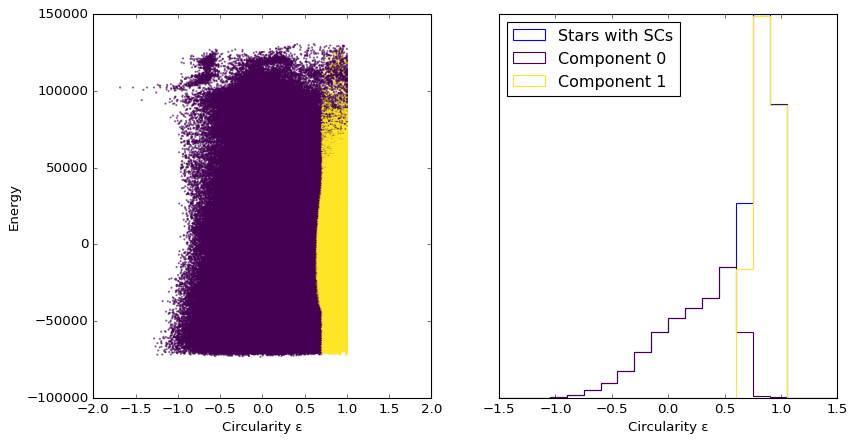

Maximum initial number of clusters per star 6
Maximum initial mass 9.73e+07 Msun
Maximum present-day mass 5.37e+07 Msun
Problematic stars with clusters 10185
That`s 8.864 per cent of stars with clusters


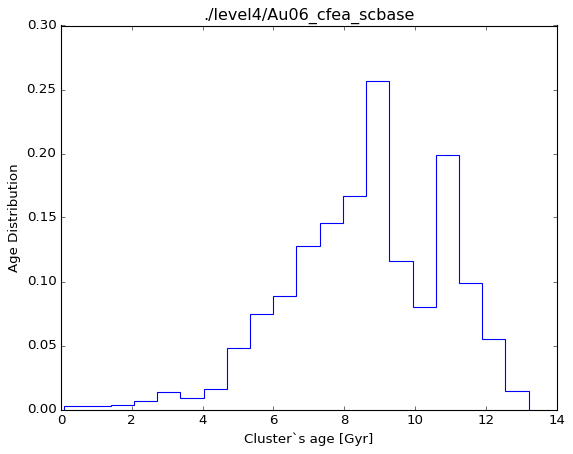

Loading simulation: ./level4/Au06_cfea_compressive
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_compressive
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0


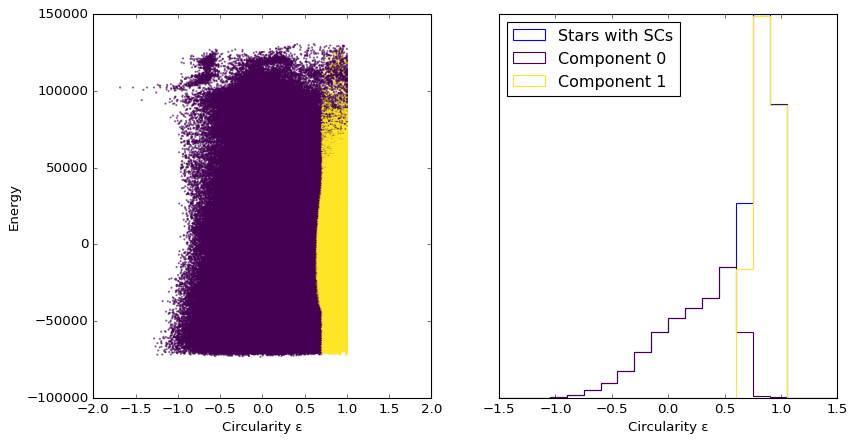

Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4072
That`s 10.135 per cent of stars with clusters


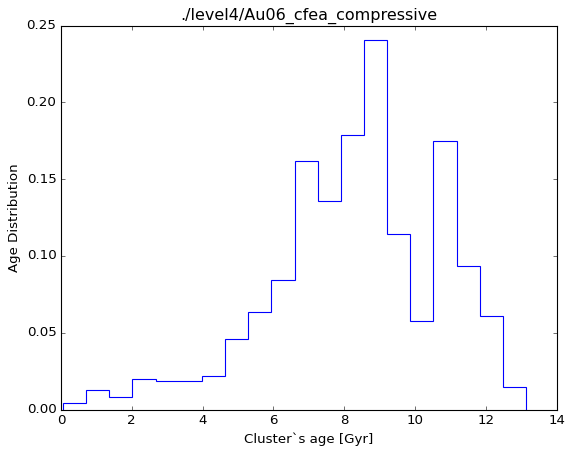

Loading simulation: ./level4/Au06_cfea_bheffect
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0


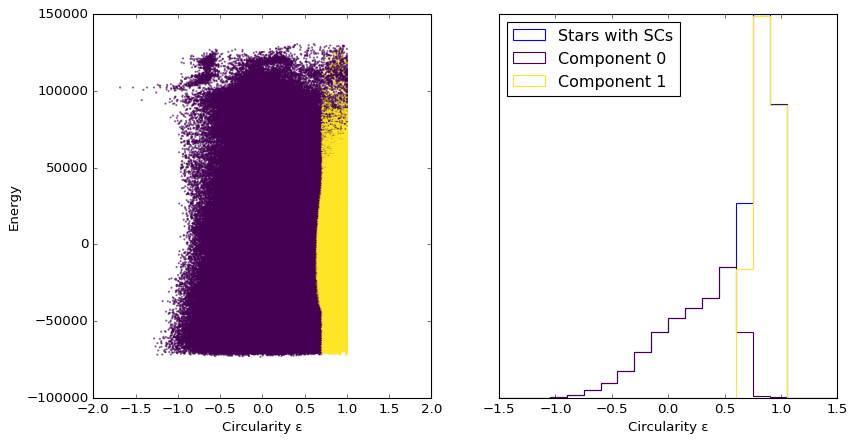

Maximum initial number of clusters per star 6
Maximum initial mass 9.73e+07 Msun
Maximum present-day mass 5.36e+07 Msun
Problematic stars with clusters 10185
That`s 8.864 per cent of stars with clusters


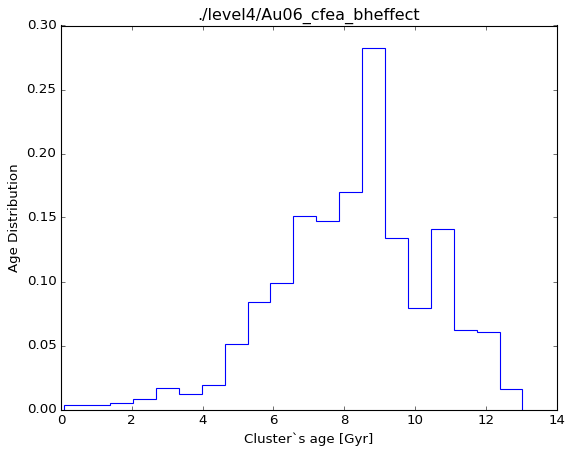

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0


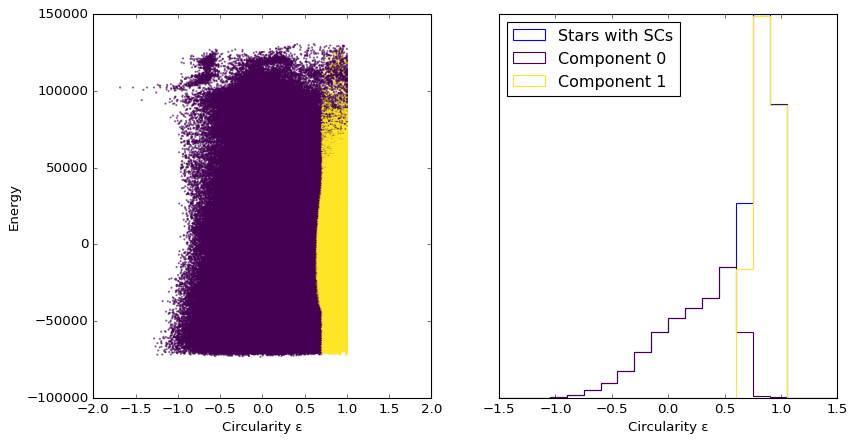

Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4072
That`s 10.135 per cent of stars with clusters


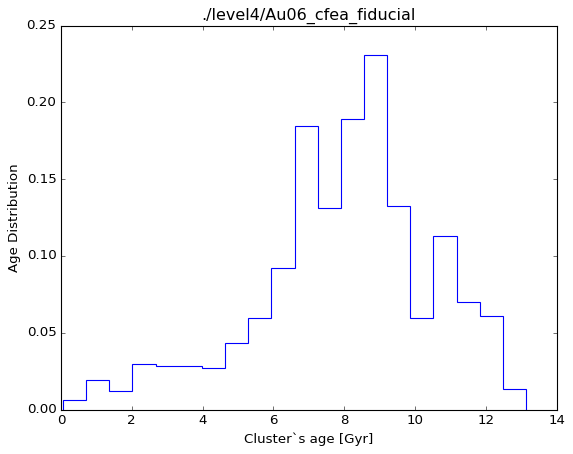

Loading simulation: ./level4/Au06_cfea_emosaics
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 9.73e+07 Msun
Maximum present-day mass 5.42e+07 Msun
Problematic stars with clusters 21225
That`s 8.631 per cent of stars with clusters


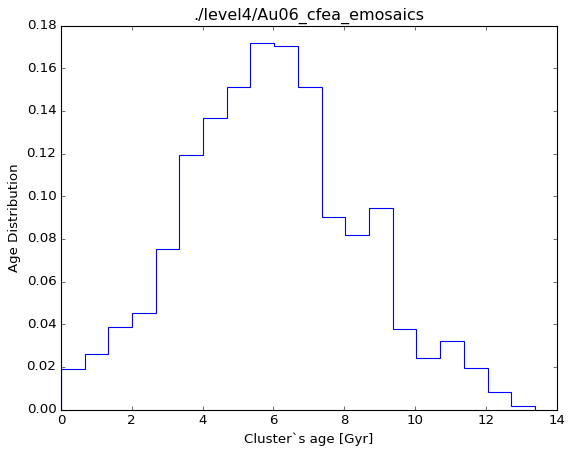

Loading simulation: ./level4/Au06_cfea_cemosaics
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.07e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters


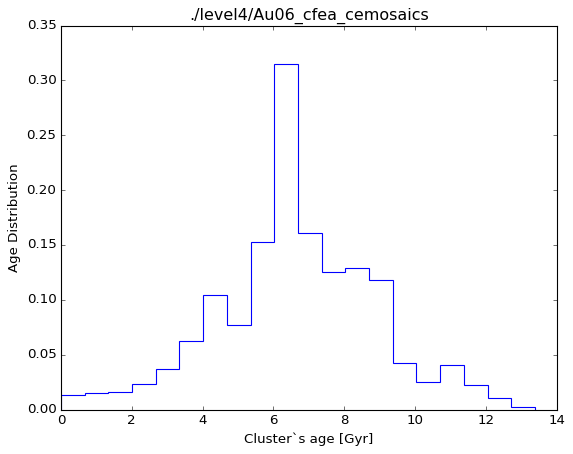

In [ ]:
base_init, base_full, base_young, base_intermediate, base_old = get_mass_functions(level4_dir+simulation_list[0], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition=None)
base_gc_init, base_gc_full, base_gc_young, base_gc_intermediate, base_gc_old = get_mass_functions(level4_dir+simulation_list[0], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition='Spheroid', \
                                                                                   plot_agedistribution=True, plot_decomposition=True, low_mass_cut=1e5)
compr_sc_init, compr_sc_full, compr_sc_young, compr_sc_intermediate, compr_sc_old = get_mass_functions(level4_dir+simulation_list[1], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition=None)
compr_gc_init, compr_gc_full, compr_gc_young, compr_gc_intermediate, compr_gc_old = get_mass_functions(level4_dir+simulation_list[1], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition='Spheroid', \
                                                                                   plot_agedistribution=True, plot_decomposition=True, low_mass_cut=1e5)
bh_gc_init, bh_gc_full, bh_gc_young, bh_gc_intermediate, bh_gc_old = get_mass_functions(level4_dir+simulation_list[2], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition='Spheroid', \
                                                                                   plot_agedistribution=True, plot_decomposition=True, low_mass_cut=1e5)
fid_sc_init, fid_sc_full, fid_sc_young, fid_sc_intermediate, fid_sc_old = get_mass_functions(level4_dir+simulation_list[3], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10.)
fid_gc_init, fid_gc_full, fid_gc_young, fid_gc_intermediate, fid_gc_old = get_mass_functions(level4_dir+simulation_list[3], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition='Spheroid', \
                                                                                   plot_agedistribution=True, plot_decomposition=True, low_mass_cut=1e5)
emoslike_init, emoslike_full, emoslike_young, emoslike_intermediate, emoslike_old = get_mass_functions(level4_dir+simulation_list[4], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition=None, \
                                                                                   plot_agedistribution=True, plot_decomposition=True, low_mass_cut=None)
cemoslike_init, cemoslike_full, cemoslike_young, cemoslike_intermediate, cemoslike_old = get_mass_functions(level4_dir+simulation_list[5], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., decomposition=None, \
                                                                                   plot_agedistribution=True, plot_decomposition=True, low_mass_cut=None)

In [6]:
original_mw = sorted([directory for directory in os.listdir(level4_dir) if 'Au' in directory and 'cfea_fiducial' in directory])
lowmass_mw = sorted([directory for directory in os.listdir(level4_dir) if 'L' in directory and 'cfea_fiducial' in directory])
dwarfs = sorted([directory for directory in os.listdir(level4_dir) if 'D' in directory and 'cfea_fiducial' in directory])

fiducial_runs = original_mw# + lowmass_mw + dwarfs
fiducial_runs.remove('Au17_cfea_fiducial')  # Exclude this unfinished simulation

In [7]:
fiducial_scs_all = []
fiducial_scs_6gyr = []
fiducial_scs_10gyr = []
fiducial_sph_all = []
fiducial_sph_6gyr = []
fiducial_sph_10gyr = []
fiducial_disc_all = []
fiducial_disc_6gyr = []
fiducial_disc_10gyr = []
fiducial_gcs_all = []
fiducial_gcs_6gyr = []
fiducial_gcs_10gyr = []

for i, sim in enumerate(fiducial_runs):
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10.)
    fiducial_scs_all.append(full)
    fiducial_scs_6gyr.append(intermediate)
    fiducial_scs_10gyr.append(old)
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid')
    fiducial_sph_all.append(full)
    fiducial_sph_6gyr.append(intermediate)
    fiducial_sph_10gyr.append(old)
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Disc')
    fiducial_disc_all.append(full)
    fiducial_disc_6gyr.append(intermediate)
    fiducial_disc_10gyr.append(old)
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e5)
    fiducial_gcs_all.append(full)
    fiducial_gcs_6gyr.append(intermediate)
    fiducial_gcs_10gyr.append(old)

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4177
That`s 10.109 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00

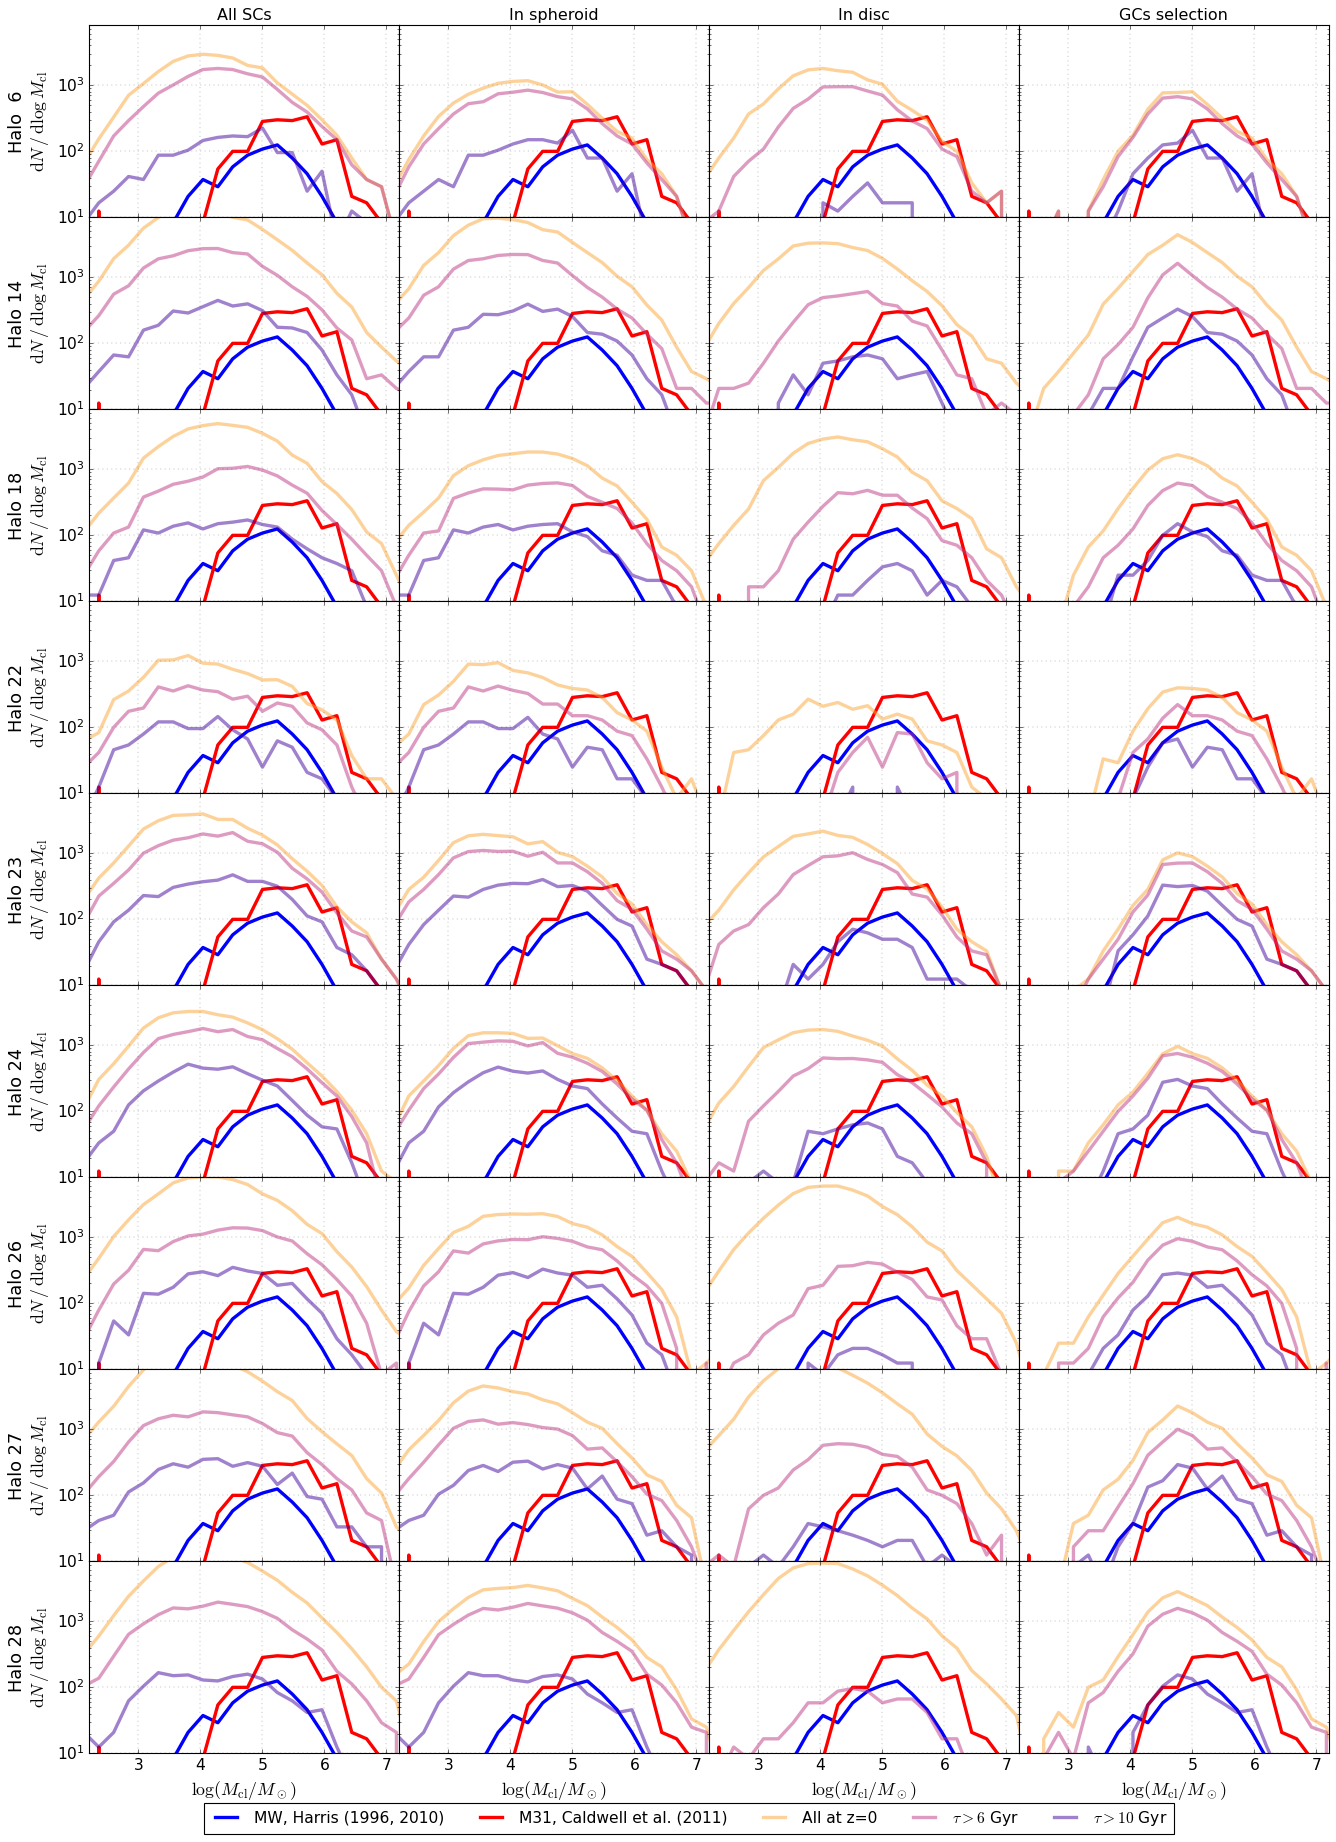

In [8]:
ncols = 4
nrows = 9
fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(ncols*5,nrows*3))
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
halo_list = [6, 14, 18, 22, 23, 24, 26, 27, 28]

for i in range(nrows):
    for j in range(ncols):
        # plot common observational MFs
        ax[i,j].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris (1996, 2010)')
        ax[i,j].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al. (2011)')

        ax[i,j].tick_params(labelsize=14)
        ax[i,j].grid(True, linewidth=0.2)
        ax[i,j].set_xlim(2.2,7.2)
 
        ax[i,j].set(ylim=(1e1,8e3), yscale= 'log')
        ax[i,j].set_xlabel(r'$\log ( M_{\mathrm{cl}} / M_\odot )$', fontsize=16)
        if(j==0): 
            ax[i,j].set_ylabel('Halo {:2d}'.format(halo_list[i])+'\n'+r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
        else: 
            ax[i,j].set_yticklabels([])

ax[0,0].set_title('All SCs')
ax[0,1].set_title('In spheroid')
ax[0,2].set_title('In disc')
ax[0,3].set_title('GCs selection')

for i in range(len(fiducial_runs)):
    # All SCs MFs
    ax[i,0].plot(marray_plot, fiducial_scs_all[i], linewidth=3, alpha=0.5, c=colors[0], label='All at z=0')
    ax[i,0].plot(marray_plot, fiducial_scs_6gyr[i], linewidth=3, alpha=0.5, c=colors[1], label=r'$\tau > 6$ Gyr')
    ax[i,0].plot(marray_plot, fiducial_scs_10gyr[i], linewidth=3, alpha=0.5, c=colors[2], label=r'$\tau>10$ Gyr')
    
    # All SCs MFs
    ax[i,1].plot(marray_plot, fiducial_sph_all[i], linewidth=3, alpha=0.5, c=colors[0], label='All at z=0')
    ax[i,1].plot(marray_plot, fiducial_sph_6gyr[i], linewidth=3, alpha=0.5, c=colors[1], label=r'$\tau > 6$ Gyr')
    ax[i,1].plot(marray_plot, fiducial_sph_10gyr[i], linewidth=3, alpha=0.5, c=colors[2], label=r'$\tau>10$ Gyr')
    
    # All SCs MFs
    ax[i,2].plot(marray_plot, fiducial_disc_all[i], linewidth=3, alpha=0.5, c=colors[0], label='All at z=0')
    ax[i,2].plot(marray_plot, fiducial_disc_6gyr[i], linewidth=3, alpha=0.5, c=colors[1], label=r'$\tau > 6$ Gyr')
    ax[i,2].plot(marray_plot, fiducial_disc_10gyr[i], linewidth=3, alpha=0.5, c=colors[2], label=r'$\tau>10$ Gyr')
    
    # All SCs MFs
    ax[i,3].plot(marray_plot, fiducial_gcs_all[i], linewidth=3, alpha=0.5, c=colors[0], label='All at z=0')
    ax[i,3].plot(marray_plot, fiducial_gcs_6gyr[i], linewidth=3, alpha=0.5, c=colors[1], label=r'$\tau > 6$ Gyr')
    ax[i,3].plot(marray_plot, fiducial_gcs_10gyr[i], linewidth=3, alpha=0.5, c=colors[2], label=r'$\tau>10$ Gyr')

plt.subplots_adjust(hspace=0, wspace=0)
# Combine all legend handles and labels from each subplot
handles, labels = [], []
for i in range(nrows):
    for j in range(ncols):
        h, l = ax[i,j].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.5, 0.07), ncols=5, fontsize=14, frameon=True)

plt.subplots_adjust(hspace=0)
plt.savefig('plots/allhalos_mfs.pdf', bbox_inches='tight')

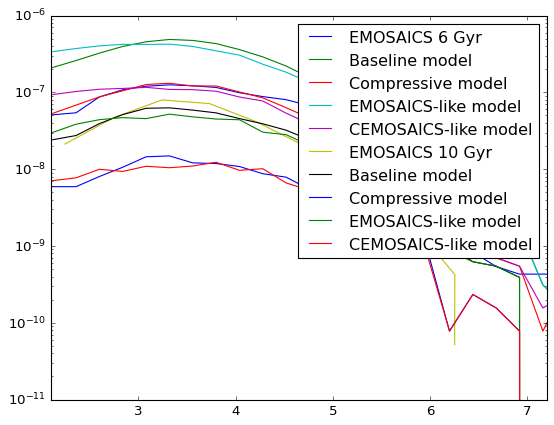

In [18]:
stellar_mass = 5.35e10 # in solar masses
emosaics_median_mass = 10**10.29 # in solar masses

plt.plot(marray_plot, np.median(emosaics_gcmf_6gyr, axis=1)/np.median(emosaics_10gal_masses), label='EMOSAICS 6 Gyr')
plt.plot(marray_plot, base_intermediate/stellar_mass, label='Baseline model')
plt.plot(marray_plot, compr_sc_intermediate/stellar_mass, label='Compressive model')
plt.plot(marray_plot, emoslike_intermediate/stellar_mass, label='EMOSAICS-like model')
plt.plot(marray_plot, cemoslike_intermediate/stellar_mass, label='CEMOSAICS-like model')

plt.plot(np.log10(emosaics_gcmf_10gyr[:,0]), emosaics_gcmf_10gyr[:,1]/emosaics_median_mass, label='EMOSAICS 10 Gyr')
plt.plot(marray_plot, base_old/stellar_mass, label='Baseline model')
plt.plot(marray_plot, compr_sc_old/stellar_mass, label='Compressive model')
plt.plot(marray_plot, emoslike_old/stellar_mass, label='EMOSAICS-like model')
plt.plot(marray_plot, cemoslike_old/stellar_mass, label='CEMOSAICS-like model')
plt.yscale('log')
plt.xlim(2.1,7.2)
plt.legend()

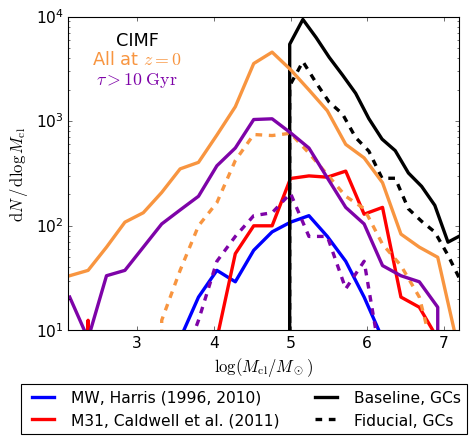

In [56]:
colors = plt.cm.plasma(1 - np.linspace(0.25,0.75,2))
styles = ['solid', 'dashed']
transparency = [0.5, 1.0]

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6,5))

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris (1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al. (2011)')
ax.set_xlim(2.1,7.2)
ax.set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=15)
ax.tick_params(labelsize=14)

ax.plot(imarray_plot, base_gc_init, c='k', linewidth=3, linestyle=styles[0], alpha=transparency[1], label='Baseline, GCs')
ax.plot(imarray_plot, fid_gc_init, c='k', linewidth=3, linestyle=styles[1], alpha=transparency[1], label='Fiducial, GCs')

ax.plot(marray_plot, base_gc_full, c=colors[0], linewidth=3, linestyle=styles[0], alpha=transparency[1])
ax.plot(marray_plot, fid_gc_full, c=colors[0], linewidth=3, linestyle=styles[1], alpha=transparency[1])

ax.plot(marray_plot, base_gc_old, c=colors[1], linewidth=3, linestyle=styles[0], alpha=transparency[1])
ax.plot(marray_plot, fid_gc_old, c=colors[1], linewidth=3, linestyle=styles[1], alpha=transparency[1])

ax.text(3, 6e3, 'CIMF', ha='center', va='center', fontsize=16)
ax.text(3, 3.9e3, r'All at $z=0$', c=colors[0], ha='center', va='center', fontsize=16)
# ax.text(3.75, 1.2e3, r'$\tau > 6 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)
ax.text(3, 2.5e3, r'$\tau > 10 \; \rm{Gyr}$', c=colors[1], ha='center', va='center', fontsize=16)

ax.set(ylim=(1e1,1e4), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)

plt.tight_layout()
ax.legend(loc='center', bbox_to_anchor=(0.45, -0.25), fontsize=14, ncols=2)

In [10]:
simulation_list = ['Au06_cfea_scbase', 'Au06_cfea_compressive', 'Au06_cfea_bheffect', 'Au06_cfea_fiducial', 'Au06_cfea_sh200myr10', 'old_Au06_cfea_sh100myr10']
variations = ['Baseline', 'Compressive', 'BH effect', 'Fiducial', 'Enhanced CCE (x10 in 200Myr)', 'Enhanced shocks (x10 full evolution)']

In [ ]:
initial_sc_population =[]
full_sc_population = []
young_sc_population = []
intermediate_sc_population = []
old_sc_population = []

initial_gc_population =[]
full_gc_population = []
young_gc_population = []
intermediate_gc_population = []
old_gc_population = []

for i, sim in enumerate(simulation_list):
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10.)
    init_gc, full_gc, young_gc, intermediate_gc, old_gc = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e5)
    initial_sc_population.append(init)
    full_sc_population.append(full)
    young_sc_population.append(young)
    intermediate_sc_population.append(intermediate)
    old_sc_population.append(old)
    initial_gc_population.append(init_gc)
    full_gc_population.append(full_gc)
    young_gc_population.append(young_gc)
    intermediate_gc_population.append(intermediate_gc)
    old_gc_population.append(old_gc)

Loading simulation: ./level4/Au06_cfea_scbase
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 9.73e+07 Msun
Maximum present-day mass 5.46e+07 Msun
Problematic stars with clusters 21225
That`s 8.631 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_scbase
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 9.73e+07 Msun
Maximum present-day mass 5.37e+07 Msun
Problematic stars with clusters 10615
That`s 8.846 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_compressive
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00

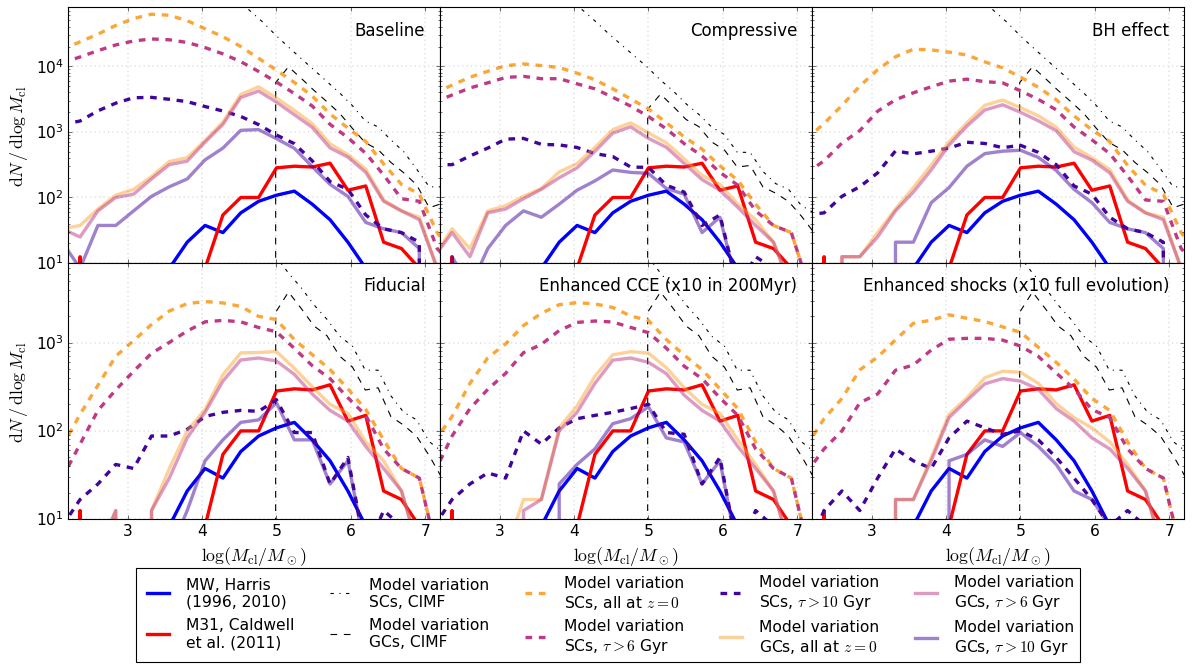

In [12]:
ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(ncols*6,nrows*4))
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))

for i in range(nrows):
    for j in range(ncols):
        # plot common observational MFs
        ax[i,j].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
        ax[i,j].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell'+'\n'+'et al. (2011)')

        # plot IMFs
        ax[i,j].plot(imarray_plot, initial_sc_population[j + i*ncols], c='k', linewidth=1, linestyle='-.', label='Model variation'+'\n'+'SCs, CIMF')
        ax[i,j].plot(imarray_plot, initial_gc_population[j + i*ncols], c='k', linewidth=1, linestyle='--', label='Model variation'+'\n'+'GCs, CIMF')
        
        # plot model variation SCs MFs 
        ax[i,j].plot(marray_plot, full_sc_population[j + i*ncols], c=colors[0], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, all at $z=0$')
        ax[i,j].plot(marray_plot, intermediate_sc_population[j + i*ncols], c=colors[1], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, $\tau > 6$ Gyr')
        ax[i,j].plot(marray_plot, old_sc_population[j + i*ncols], c=colors[2], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, $\tau > 10$ Gyr')
        
        # plot model variation GCs MFs 
        ax[i,j].plot(marray_plot, full_gc_population[j + i*ncols], c=colors[0], linewidth=3, alpha=0.5, label='Model variation'+'\n'+r'GCs, all at $z=0$')
        ax[i,j].plot(marray_plot, intermediate_gc_population[j + i*ncols], c=colors[1], linewidth=3, alpha=0.5, label='Model variation'+'\n'+r'GCs, $\tau > 6$ Gyr')
        ax[i,j].plot(marray_plot, old_gc_population[j + i*ncols], c=colors[2], linewidth=3, alpha=0.5, label='Model variation'+'\n'+r'GCs, $\tau > 10$ Gyr')

        ax[i,j].tick_params(labelsize=14)
        ax[i,j].grid(True, linewidth=0.2)
        ax[i,j].set_xlim(2.2,7.2)

        if(i==0): 
            ax[i,j].set(ylim=(1e1,8e4), yscale= 'log')
            ax[i,j].text(7., 3e4, variations[j + i*ncols], fontsize=15, ha='right')
        else: 
            ax[i,j].set(ylim=(1e1,8e3), yscale= 'log')
            ax[i,j].text(7., 4e3, variations[j + i*ncols], fontsize=15, ha='right')
            ax[i,j].set_xlabel(r'$\log ( M_{\mathrm{cl}} / M_\odot )$', fontsize=16)
        if(j==0): 
            ax[i,j].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
        else: 
            ax[i,j].set_yticklabels([])

# for run in fiducial_gcs:
#     ax[1,0].plot(marray_plot, run, c='gray', alpha=0.4, linestyle='solid', linewidth = 1, label='All fiducial runs,'+'\n'+r'GCs, $\tau > 6$ Gyr')

plt.subplots_adjust(hspace=0, wspace=0)
# Combine all legend handles and labels from each subplot
handles, labels = [], []
for i in range(nrows):
    for j in range(ncols):
        h, l = ax[i,j].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.5, -0.05), ncols=5, fontsize=14, frameon=True)

plt.subplots_adjust(hspace=0)
plt.savefig('plots/model_variations_mfs_paper.pdf', bbox_inches='tight')

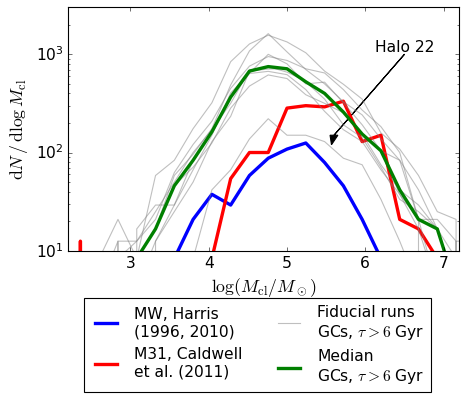

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

# Make the colormap semi-transparent by replacing it with an alpha-modified version
# alpha = 0.75  # desired transparency for the colorbar colors (0.0 fully transparent, 1.0 opaque)
# _base = cm.tab10
# _colors = _base(np.linspace(0, 0.89, 256))
# _colors[:, 3] = alpha
# cm.mod_cmap = mcolors.ListedColormap(_colors, name='mod_cmap')
# # Set up colormap
# cmap = cm.mod_cmap   # Or "viridis", "inferno", etc.
# norm = mcolors.Normalize(vmin=0, vmax=len(fiducial_runs)-1)

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell'+'\n'+'et al. (2011)')

for i in range(len(fiducial_runs)):
    ax.plot(marray_plot, fiducial_gcs_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')

ax.plot(marray_plot, np.median(np.array(fiducial_gcs_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
# ax.plot(marray_plot, np.median(np.array(fiducial_gcs_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')

ax.arrow(6.5, 1e3, -0.9, -850, head_width=0.1, head_length=30, color='k')
ax.text(6.5, 1e3, 'Halo 22', va='bottom', ha='center', fontsize=14)

ax.set_xlim(2.2,7.2)
ax.set(ylim=(1e1,3e3), yscale= 'log')
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\log ( M_{\mathrm{cl}} / M_\odot )$', fontsize=16)
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)

plt.tight_layout()
handles, labels = [], []
h, l = ax.get_legend_handles_labels()
handles.extend(h)
labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.55, -0.1), ncols=2, fontsize=14, frameon=True)

# Add colorbar as legend
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Required for colorbar
# cbar = fig.colorbar(sm, cax=fig.add_axes([0.03, 1., .95, 0.02]), orientation='horizontal')
# cbar.ax.set_title('Fiducial runs, Halo ID', fontsize=16)
# cbar.set_ticks(np.arange(0, len(fiducial_gcs), 1))  # adjust ticks (optional)
# cbar.set_ticklabels([6,14,18,22,23,24,26,27,28])
# cbar.ax.tick_params(labelsize=14)

plt.savefig('plots/fiducial_gcmf_paper.pdf', bbox_inches='tight')

In [9]:
fiducial_gcs_1e4_all = []
fiducial_gcs_1e4_6gyr = []
fiducial_gcs_1e4_10gyr = []

fiducial_gcs_1e5_all = fiducial_gcs_all
fiducial_gcs_1e5_6gyr = fiducial_gcs_6gyr
fiducial_gcs_1e5_10gyr = fiducial_gcs_10gyr

fiducial_gcs_1e6_all = []
fiducial_gcs_1e6_6gyr = []
fiducial_gcs_1e6_10gyr = []

for i, sim in enumerate(fiducial_runs):
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e4)
    fiducial_gcs_1e4_all.append(full)
    fiducial_gcs_1e4_6gyr.append(intermediate)
    fiducial_gcs_1e4_10gyr.append(old)
    # init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e5)
    # fiducial_gcs_1e5_all.append(full)
    # fiducial_gcs_1e5_6gyr.append(intermediate)
    # fiducial_gcs_1e5_10gyr.append(old)
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e6)
    fiducial_gcs_1e6_all.append(full)
    fiducial_gcs_1e6_6gyr.append(intermediate)
    fiducial_gcs_1e6_10gyr.append(old)

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4177
That`s 10.109 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4177
That`s 10.109 per cent of stars with clusters
Loading simulation: ./level4/Au14_cfea_fiducial
galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 1.23e+11 Msun
Redsh

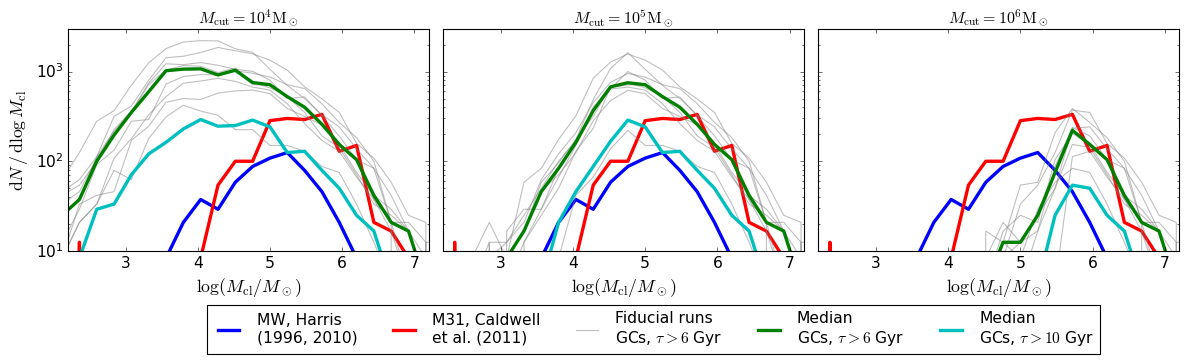

In [19]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,4))

for axis in ax:
    axis.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
    axis.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell'+'\n'+'et al. (2011)')
    axis.set_xlim(2.2,7.2)
    axis.set(ylim=(1e1,3e3), yscale= 'log')
    axis.tick_params(labelsize=14)
    axis.set_xlabel(r'$\log ( M_{\mathrm{cl}} / M_\odot )$', fontsize=16)

ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)

for i in range(len(fiducial_runs)):
    ax[0].plot(marray_plot, fiducial_gcs_1e4_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')
    ax[1].plot(marray_plot, fiducial_gcs_1e5_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')
    ax[2].plot(marray_plot, fiducial_gcs_1e6_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')

ax[0].plot(marray_plot, np.median(np.array(fiducial_gcs_1e4_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
ax[1].plot(marray_plot, np.median(np.array(fiducial_gcs_1e5_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
ax[2].plot(marray_plot, np.median(np.array(fiducial_gcs_1e6_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
ax[0].plot(marray_plot, np.median(np.array(fiducial_gcs_1e4_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')
ax[1].plot(marray_plot, np.median(np.array(fiducial_gcs_1e5_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')
ax[2].plot(marray_plot, np.median(np.array(fiducial_gcs_1e6_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')

ax[0].set_title(r'$M_\mathrm{cut} = 10^4 \mathrm{M}_\odot$')
ax[1].set_title(r'$M_\mathrm{cut} = 10^5 \mathrm{M}_\odot$')
ax[2].set_title(r'$M_\mathrm{cut} = 10^6 \mathrm{M}_\odot$')


plt.tight_layout()
handles, labels = [], []
for axis in ax:
    h, l = axis.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.55, -0.05), ncols=5, fontsize=14, frameon=True)
plt.savefig('plots/initial_cut_effect_1.pdf', bbox_inches='tight')

In [11]:
fiducial_gcs_5e4_all = []
fiducial_gcs_5e4_6gyr = []
fiducial_gcs_5e4_10gyr = []

# fiducial_gcs_1e5_all = []
# fiducial_gcs_1e5_6gyr = []
# fiducial_gcs_1e5_10gyr = []

fiducial_gcs_5e5_all = []
fiducial_gcs_5e5_6gyr = []
fiducial_gcs_5e5_10gyr = []

for i, sim in enumerate(fiducial_runs):
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=5e4)
    fiducial_gcs_5e4_all.append(full)
    fiducial_gcs_5e4_6gyr.append(intermediate)
    fiducial_gcs_5e4_10gyr.append(old)
    # init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e5)
    # fiducial_gcs_1e5_all.append(full)
    # fiducial_gcs_1e5_6gyr.append(intermediate)
    # fiducial_gcs_1e5_10gyr.append(old)
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=5e5)
    fiducial_gcs_5e5_all.append(full)
    fiducial_gcs_5e5_6gyr.append(intermediate)
    fiducial_gcs_5e5_10gyr.append(old)

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4177
That`s 10.109 per cent of stars with clusters
Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 5.33e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 4177
That`s 10.109 per cent of stars with clusters
Loading simulation: ./level4/Au14_cfea_fiducial
galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 1.23e+11 Msun
Redsh

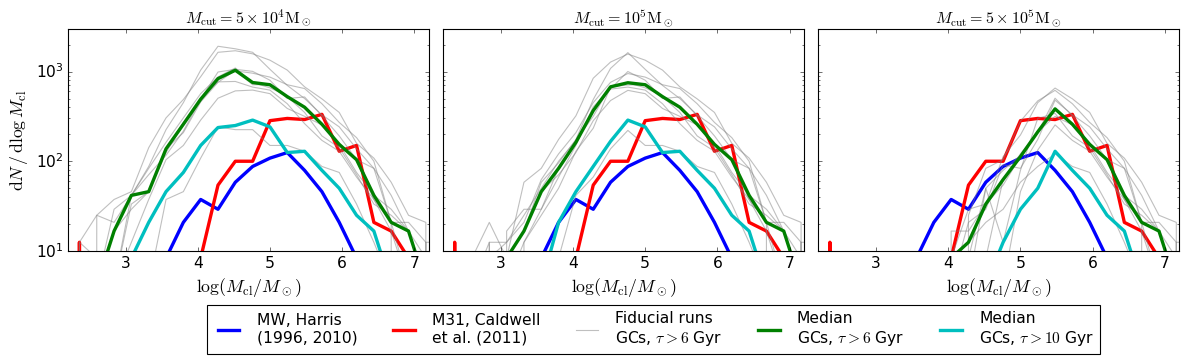

In [18]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,4))

for axis in ax:
    axis.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
    axis.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell'+'\n'+'et al. (2011)')
    axis.set_xlim(2.2,7.2)
    axis.set(ylim=(1e1,3e3), yscale= 'log')
    axis.tick_params(labelsize=14)
    axis.set_xlabel(r'$\log ( M_{\mathrm{cl}} / M_\odot )$', fontsize=16)

ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)

for i in range(len(fiducial_runs)):
    ax[0].plot(marray_plot, fiducial_gcs_5e4_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')
    ax[1].plot(marray_plot, fiducial_gcs_1e5_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')
    ax[2].plot(marray_plot, fiducial_gcs_5e5_6gyr[i], linewidth=1, alpha=0.5, c='gray', label='Fiducial runs'+'\n'+r'GCs, $\tau > 6$ Gyr')

ax[0].plot(marray_plot, np.median(np.array(fiducial_gcs_5e4_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
ax[1].plot(marray_plot, np.median(np.array(fiducial_gcs_1e5_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
ax[2].plot(marray_plot, np.median(np.array(fiducial_gcs_5e5_6gyr), axis=0), linewidth=3, c='g', label='Median'+'\n'+r'GCs, $\tau > 6$ Gyr')
ax[0].plot(marray_plot, np.median(np.array(fiducial_gcs_5e4_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')
ax[1].plot(marray_plot, np.median(np.array(fiducial_gcs_1e5_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')
ax[2].plot(marray_plot, np.median(np.array(fiducial_gcs_5e5_10gyr), axis=0), linewidth=3, c='c', label='Median'+'\n'+r'GCs, $\tau > 10$ Gyr')

ax[0].set_title(r'$M_\mathrm{cut} = 5\times 10^4 \mathrm{M}_\odot$')
ax[1].set_title(r'$M_\mathrm{cut} = 10^5 \mathrm{M}_\odot$')
ax[2].set_title(r'$M_\mathrm{cut} = 5\times 10^5 \mathrm{M}_\odot$')


plt.tight_layout()
handles, labels = [], []
for axis in ax:
    h, l = axis.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.55, -0.05), ncols=5, fontsize=14, frameon=True)
plt.savefig('plots/initial_cut_effect_2.pdf', bbox_inches='tight')

In [13]:
simulation_list = ['Au06_e5813_4pcnodrh_116', 'Au06_e5813_4pcwdrh_116', 'Au06_e5813_fid116_nodrh', 'Au06_cfea_fiducial']
variations = [r'$r_\mathrm{h,0}=4\mathrm{pc}, \mathrm{d}r_\mathrm{h}=0$',
              r'$r_\mathrm{h,0}=4\mathrm{pc}, \mathrm{d}r_\mathrm{h}=f(\mathrm{d}m)$',
              r'$r_\mathrm{h,0}=f(m_0), \mathrm{d}r_\mathrm{h}=0$',
              r'$r_\mathrm{h,0}=f(m_0), \mathrm{d}r_\mathrm{h}=f(\mathrm{d}m)$']

In [14]:
initial_sc_population =[]
full_sc_population = []
young_sc_population = []
intermediate_sc_population = []
old_sc_population = []

for i, sim in enumerate(simulation_list):
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=106, subdir='/output/', age_intermediate=6., age_old=10.)
    initial_sc_population.append(init)
    full_sc_population.append(full)
    young_sc_population.append(young)
    intermediate_sc_population.append(intermediate)
    old_sc_population.append(old)

Loading simulation: ./level4/Au06_e5813_4pcnodrh_116
galrad= 0.01828204
Found 1226157 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 4.97e+10 Msun
Redshift of the simulation: 0.29
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 2.98e+07 Msun
Problematic stars with clusters 6655
That`s 9.951 per cent of stars with clusters
Loading simulation: ./level4/Au06_e5813_4pcwdrh_116
galrad= 0.01828204
Found 1226157 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 4.97e+10 Msun
Redshift of the simulation: 0.29
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.00e+07 Msun
Problematic stars with clusters 6655
That`s 9.951 per cent of stars with clusters
Loading simulation: ./level4/Au06_e5813_fid116_nodrh
galrad= 0.01828204
Found 1226157 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 4.97e+10 Msun
Redshift of the simulation: 0.29
Maximum initial

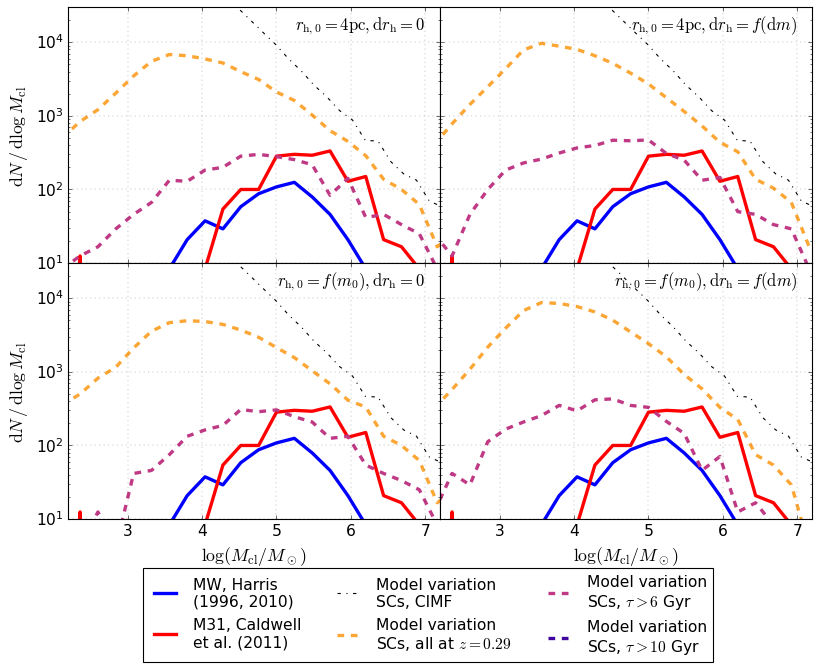

In [15]:
ncols = 2
nrows = 2
fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(ncols*6,nrows*4))
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))

for i in range(nrows):
    for j in range(ncols):
        # plot common observational MFs
        ax[i,j].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
        ax[i,j].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell'+'\n'+'et al. (2011)')

        # plot IMFs
        ax[i,j].plot(imarray_plot, initial_sc_population[j + i*ncols], c='k', linewidth=1, linestyle='-.', label='Model variation'+'\n'+'SCs, CIMF')
        
        # plot model variation SCs MFs 
        ax[i,j].plot(marray_plot, full_sc_population[j + i*ncols], c=colors[0], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, all at $z=0.29$')
        ax[i,j].plot(marray_plot, intermediate_sc_population[j + i*ncols], c=colors[1], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, $\tau > 6$ Gyr')
        ax[i,j].plot(marray_plot, old_sc_population[j + i*ncols], c=colors[2], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, $\tau > 10$ Gyr')
        
        ax[i,j].tick_params(labelsize=14)
        ax[i,j].grid(True, linewidth=0.2)
        ax[i,j].set_xlim(2.2,7.2)

        ax[i,j].set(ylim=(1e1,3e4), yscale= 'log')
        ax[i,j].text(7., 1.5e4, variations[j + i*ncols], fontsize=15, ha='right')
        if i==1:
            ax[i,j].set_xlabel(r'$\log ( M_{\mathrm{cl}} / M_\odot )$', fontsize=16)
        if(j==0): 
            ax[i,j].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
        else: 
            ax[i,j].set_yticklabels([])


plt.subplots_adjust(hspace=0, wspace=0)
# Combine all legend handles and labels from each subplot
handles, labels = [], []
for i in range(nrows):
    for j in range(ncols):
        h, l = ax[i,j].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.5, -0.05), ncols=3, fontsize=14, frameon=True)

plt.subplots_adjust(hspace=0)
plt.savefig('plots/rh_evolution_test.pdf', bbox_inches='tight')

In [ ]:
simulation_list = ['Au06_cfea_fiducial', 'Au06_e5813_fid_067']
variations = [r'$\bar{m}=1.16 \mathrm{M}_\odot$', r'$\bar{m}=0.67 \mathrm{M}_\odot$']

initial_sc_population =[]
full_sc_population = []
young_sc_population = []
intermediate_sc_population = []
old_sc_population = []

for i, sim in enumerate(simulation_list):
    init, full, young, intermediate, old = get_mass_functions(level4_dir+sim, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10.)
    initial_sc_population.append(init)
    full_sc_population.append(full)
    young_sc_population.append(young)
    intermediate_sc_population.append(intermediate)
    old_sc_population.append(old)

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters
Loading simulation: ./level4/Au06_e5813_fid_067
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters


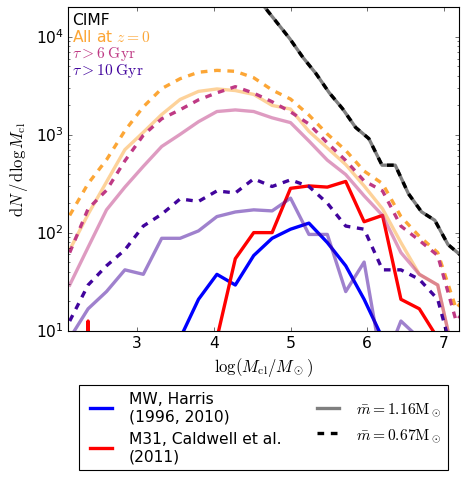

In [ ]:
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
styles = ['solid', 'dashed']
transparency = [0.5, 1.0]

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6,5))

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al.'+'\n'+'(2011)')
ax.set_xlim(2.1,7.2)
ax.set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=15)
ax.tick_params(labelsize=14)

for i, mf in enumerate(initial_sc_population):
  ax.plot(imarray_plot, mf, c='k', linewidth=3, linestyle=styles[i], alpha=transparency[i], label=variations[i])

for i, mf in enumerate(full_sc_population):
  ax.plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle=styles[i], alpha=transparency[i])

for i, mf in enumerate(intermediate_sc_population):
  ax.plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle=styles[i], alpha=transparency[i])
  
for i,mf in enumerate(old_sc_population):
  ax.plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle=styles[i], alpha=transparency[i])

ax.text(2.15, 1.5e4, 'CIMF', ha='left', va='center', fontsize=14)
ax.text(2.15, 1e4, r'All at $z=0$', ha='left', va='center', color=colors[0], fontsize=14)
ax.text(2.15, 6.75e3, r'$\tau > 6 \; \rm{Gyr}$', ha='left', va='center', color=colors[1], fontsize=14)
ax.text(2.15, 4.5e3, r'$\tau > 10 \; \rm{Gyr}$', ha='left', va='center', color=colors[2], fontsize=14)

ax.set(ylim=(1e1,2e4), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)

plt.tight_layout()
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fontsize=14, ncols=2)

In [16]:
simulation_list = [level4_dir+'Au06_cfea_fiducial', level5_dir+'Au06_e5813_fiducial', level6_dir+'Au06_e5813_fiducial']
variations = ['Level 4', 'Level 5', 'Level 6']

initial_sc_population =[]
full_sc_population = []
young_sc_population = []
intermediate_sc_population = []
old_sc_population = []

for sim in simulation_list:
    init, full, young, intermediate, old = get_mass_functions(sim, snapshot=127, age_intermediate=6, age_old=10)
    initial_sc_population.append(init)
    full_sc_population.append(full)
    young_sc_population.append(young)
    intermediate_sc_population.append(intermediate)
    old_sc_population.append(old)

Loading simulation: ./level4/Au06_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters 6873
That`s 9.895 per cent of stars with clusters
Loading simulation: ./level5/Au06_e5813_fiducial
galrad= 0.021445496
Found 173049 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 5.36e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 14
Maximum initial mass 5.02e+07 Msun
Maximum present-day mass 2.73e+07 Msun
Problematic stars with clusters  912
That`s 2.592 per cent of stars with clusters
Loading simulation: ./level6/Au06_e5813_fiducial
galrad= 0.021225145
Found 11621 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.72e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of 

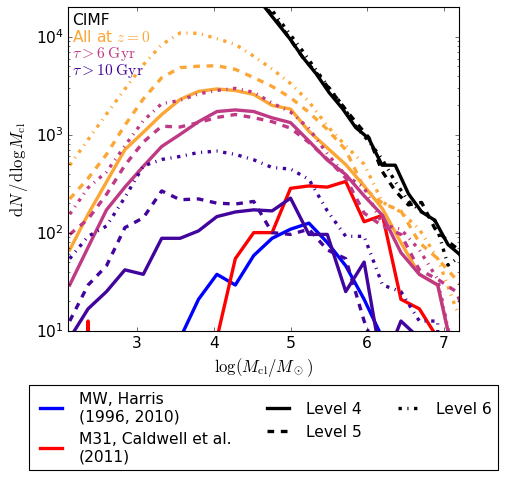

In [17]:
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
styles = ['solid', 'dashed', 'dashdot']
transparency = [0.5, 0.75, 1.0]

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6,5))

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al.'+'\n'+'(2011)')
ax.set_xlim(2.1,7.2)
ax.set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=15)
ax.tick_params(labelsize=14)

for i, mf in enumerate(initial_sc_population):
  ax.plot(imarray_plot, mf, c='k', linewidth=3, linestyle=styles[i], label=variations[i])

for i, mf in enumerate(full_sc_population):
  ax.plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle=styles[i])

for i, mf in enumerate(intermediate_sc_population):
  ax.plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle=styles[i])
  
for i,mf in enumerate(old_sc_population):
  ax.plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle=styles[i])

ax.text(2.15, 1.5e4, 'CIMF', ha='left', va='center', fontsize=14)
ax.text(2.15, 1e4, r'All at $z=0$', ha='left', va='center', color=colors[0], fontsize=14)
ax.text(2.15, 6.75e3, r'$\tau > 6 \; \rm{Gyr}$', ha='left', va='center', color=colors[1], fontsize=14)
ax.text(2.15, 4.5e3, r'$\tau > 10 \; \rm{Gyr}$', ha='left', va='center', color=colors[2], fontsize=14)

ax.set(ylim=(1e1,2e4), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)

plt.tight_layout()
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fontsize=14, ncols=3)
plt.savefig('plots/resolution_test.pdf', bbox_inches='tight')

In [ ]:
simulation_list = [directory for directory in os.listdir(level5_dir) if 'LMW6_cfea' in directory]
print(simulation_list)
simulation_list = [simulation_list[0], simulation_list[1]]
print(simulation_list)

['LMW6_cfea_fiducial', 'LMW6_cfea_fulltensor', 'LMW6_cfea_rhevo_f1', 'LMW6_cfea_rhevo_f1_2', 'LMW6_cfea_units']
['LMW6_cfea_fulltensor', 'LMW6_cfea_fiducial']


In [ ]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
model = ['Tree tidal'+'\n'+'tensor', 'Tree+PM tidal'+'\n'+'tensor']

for sim in simulation_list:
    # labels.append(sim)
    init, full, young, intermediate, old = get_mass_functions(level5_dir+sim, snapshot=127, age_intermediate=6, decomposition=None)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_fiducial
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 11
Maximum initial mass 5.00e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters  330
That`s 1.634 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_fulltensor
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 12
Maximum initial mass 1.83e+07 Msun
Maximum present-day mass 9.99e+06 Msun
Problematic stars with clusters  333
That`s 1.590 per cent of stars with clusters


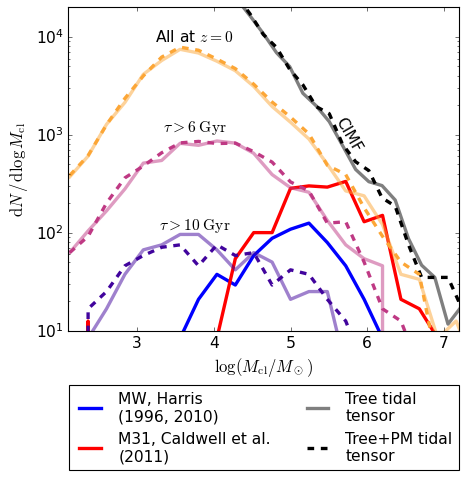

In [20]:
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
styles = ['solid', 'dashed']
transparency = [0.5, 1.0]

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6,5))

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al.'+'\n'+'(2011)')
ax.set_xlim(2.1,7.2)
ax.set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=15)
ax.tick_params(labelsize=14)

for i, mf in enumerate(initial_population):
  ax.plot(imarray_plot, mf, c='k', linewidth=3, linestyle=styles[i], alpha=transparency[i], label=model[i])

for i, mf in enumerate(full_population):
  ax.plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle=styles[i], alpha=transparency[i])

for i, mf in enumerate(intermediate_population):
  ax.plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle=styles[i], alpha=transparency[i])
  
for i,mf in enumerate(old_population):
  ax.plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle=styles[i], alpha=transparency[i])

ax.text(5.75, 1e3, 'CIMF', ha='center', va='center', fontsize=14, rotation=-60)
ax.text(3.75, 1e4, r'All at $z=0$', ha='center', va='center', fontsize=14)
ax.text(3.75, 1.2e3, r'$\tau > 6 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)
ax.text(3.75, 1.2e2, r'$\tau > 10 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)

ax.set(ylim=(1e1,2e4), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)

plt.tight_layout()
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fontsize=14, ncols=2)
# plt.subplots_adjust(wspace=0)
plt.savefig('plots/fulltensor_mfs_paper.pdf', bbox_inches='tight')

In [21]:
simulation_list = [directory for directory in os.listdir(level5_dir) if 'LMW6_cfea' in directory]
print(simulation_list)
simulation_list = [simulation_list[0], simulation_list[3], simulation_list[2]]
print(simulation_list)

['LMW6_cfea_fiducial', 'LMW6_cfea_fulltensor', 'LMW6_cfea_rhevo_f1', 'LMW6_cfea_rhevo_f1_2', 'LMW6_cfea_units']
['LMW6_cfea_fiducial', 'LMW6_cfea_rhevo_f1_2', 'LMW6_cfea_rhevo_f1']


In [ ]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
model = [r'$f=3/5, \; (d\rho_\mathrm{h})_\mathrm{sh} = 0$', r'$f=1/2, \; (dr_\mathrm{h})_\mathrm{sh} = 0$', r'$f=1, \; (d\rho_\mathrm{h})_\mathrm{sh} > 0$']

for sim in simulation_list:
    # labels.append(sim)
    init, full, young, intermediate, old = get_mass_functions(level5_dir+sim, snapshot=127, age_intermediate=6, decomposition=None)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_fiducial
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 11
Maximum initial mass 5.00e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters  330
That`s 1.634 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_rhevo_f1_2
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 11
Maximum initial mass 5.00e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters  330
That`s 1.634 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_rhevo_f1
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.0

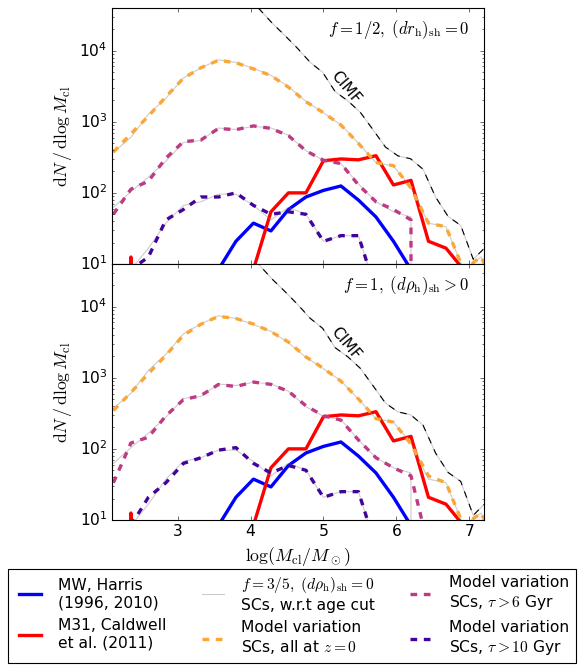

In [23]:
nsubs = 2
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))

fig, ax = plt.subplots(nsubs, 1, sharex=True, figsize=(6, nsubs*4))

for i in range(len(ax)):
  ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris'+'\n'+'(1996, 2010)')
  ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell'+'\n'+'et al. (2011)')
  ax[i].tick_params(labelsize=14)
  ax[i].text(7, 2e4, model[i+1], ha='right', va='center', fontsize=15)
  ax[i].text(5.3, 3e3, 'CIMF', ha='center', va='center', fontsize=14, rotation=-50)
  ax[i].set(ylim=(1e1,4e4), yscale= 'log')
  ax[i].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)

for i in range(len(ax)):
  ax[i].plot(imarray_plot, initial_population[0], c='grey', linewidth=1, linestyle='solid', alpha=0.4)
  ax[i].plot(marray_plot, full_population[0], c='grey', linewidth=1, linestyle='solid', alpha=0.4, label=model[0]+'\n'+'SCs, w.r.t age cut')
  ax[i].plot(marray_plot, intermediate_population[0], c='grey', linewidth=1, linestyle='solid', alpha=0.4)
  ax[i].plot(marray_plot, old_population[0], c='grey', linewidth=1, linestyle='solid', alpha=0.4)

for i,mf in enumerate(initial_population[1:]):
  ax[i].plot(imarray_plot, mf, c='k', linewidth=1, linestyle='--')#, label='CIMF, same'+'\n'+ 'for all models')

for i,mf in enumerate(full_population[1:]):
  ax[i].plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, all at $z=0$')

for i,mf in enumerate(intermediate_population[1:]):
  ax[i].plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, $\tau > 6$ Gyr')
  
for i,mf in enumerate(old_population[1:]):
  ax[i].plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle='--', label='Model variation'+'\n'+r'SCs, $\tau > 10$ Gyr')

ax[1].set_xlim(2.1,7.2)
ax[1].set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=16)

plt.subplots_adjust(hspace=0)
# Combine all legend handles and labels from each subplot
handles, labels = [], []
for i in range(len(ax)):
    h, l = ax[i].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='center', bbox_to_anchor=(0.5, -0.05), ncols=3, fontsize=14, frameon=True)

plt.savefig('plots/lvl5_ftest_mfs_paper.pdf', bbox_inches='tight')

In [ ]:
simulation_list = [directory for directory in os.listdir(level5_dir) if 'LMW6_2966' in directory]
print(simulation_list)

['LMW6_2966_form', 'LMW6_2966_phiptest']


In [ ]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
model = ['fiducial', 'phip_test']

for sim in simulation_list:
    # labels.append(sim)
    init, full, young, intermediate, old = get_mass_functions(level5_dir+sim, snapshot=127, age_intermediate=6, decomposition=None)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

Loading simulation: ./lvl5_testruns/Au06_lvl5_2966_form
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 12
Maximum initial mass 1.83e+07 Msun
Maximum present-day mass 9.99e+06 Msun
Problematic stars with clusters  333
That`s 1.590 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au06_lvl5_2966_phiptest
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 12
Maximum initial mass 1.83e+07 Msun
Maximum present-day mass 9.99e+06 Msun
Problematic stars with clusters  333
That`s 1.590 per cent of stars with clusters


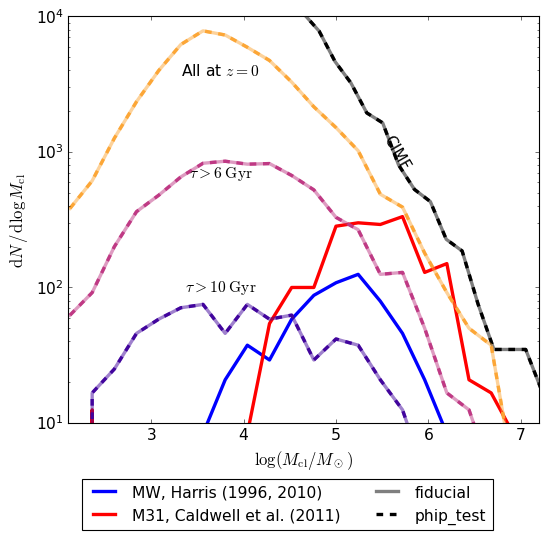

In [20]:
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
styles = ['solid', 'dashed']
transparency = [0.5, 1.0]

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(7,7))

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris (1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al. (2011)')
ax.set_xlim(2.1,7.2)
ax.set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=15)
ax.tick_params(labelsize=14)

for i, mf in enumerate(initial_population):
  ax.plot(imarray_plot, mf, c='k', linewidth=3, linestyle=styles[i], alpha=transparency[i], label=model[i])

for i, mf in enumerate(full_population):
  ax.plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle=styles[i], alpha=transparency[i])

for i, mf in enumerate(intermediate_population):
  ax.plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle=styles[i], alpha=transparency[i])
  
for i,mf in enumerate(old_population):
  ax.plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle=styles[i], alpha=transparency[i])

ax.text(5.65, 1e3, 'CIMF', ha='center', va='center', fontsize=14, rotation=-60)
ax.text(3.75, 4e3, r'All at $z=0$', ha='center', va='center', fontsize=14)
ax.text(3.75, 7e2, r'$\tau > 6 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)
ax.text(3.75, 1e2, r'$\tau > 10 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)

ax.set(ylim=(1e1,1e4), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax.legend(loc='center', bbox_to_anchor=(0.465, -0.2), fontsize=14, ncols=2)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/fulltensor_mfs_paper.pdf')

In [18]:
simulation_list = [directory for directory in os.listdir(level5_dir) if 'LMW6' in directory]
print(simulation_list)
simulation_list = [simulation_list[5], simulation_list[4], simulation_list[2], simulation_list[3]]
print(simulation_list)

['LMW6_04d8_artifcce', 'LMW6_065c_coldphase', 'LMW6_0ebd_mmsm', 'LMW6_0ebd_mmsmwtbh', 'LMW6_0ebd_smsm', 'LMW6_0ebd_smsmnobh', 'LMW6_2966_form', 'LMW6_2966_phiptest', 'LMW6_31a28_GG23', 'LMW6_31a2_eqrhnoevo', 'LMW6_814c_cce_tview', 'LMW6_814c_fimf_cce_tview', 'LMW6_814c_fimf_tview', 'LMW6_814c_tview', 'LMW6_cfea_fiducial', 'LMW6_cfea_fulltensor', 'LMW6_cfea_rhevo_f1', 'LMW6_cfea_rhevo_f1_2', 'LMW6_cfea_units', 'LMW6_ec9e_10myr', 'LMW6_ec9e_cce_10myr', 'LMW6_ec9e_fimf_10myr', 'LMW6_ec9e_fimf_cce_10myr', 'LMW6_ef7d_fiducial', 'LMW6_ef7d_sh100myr10', 'LMW6_ef7d_sh50myr10']
['LMW6_0ebd_smsmnobh', 'LMW6_0ebd_smsm', 'LMW6_0ebd_mmsm', 'LMW6_0ebd_mmsmwtbh']


In [ ]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
model = ['equal-mass', 'equal-mass+BH', 'multi-mass', 'multi-mass+BH']

for sim in simulation_list:
    # labels.append(sim)
    init, full, young, intermediate, old = get_mass_functions(level5_dir+sim, snapshot=127, age_intermediate=6, decomposition=None)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

Loading simulation: ./lvl5_testruns/Au06_lvl5_0ebd_smsmnobh
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 11
Maximum initial mass 5.00e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters  330
That`s 1.634 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au06_lvl5_0ebd_smsm
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 11
Maximum initial mass 5.00e+07 Msun
Maximum present-day mass 3.09e+07 Msun
Problematic stars with clusters  330
That`s 1.634 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au06_lvl5_0ebd_mmsm
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
Maxim

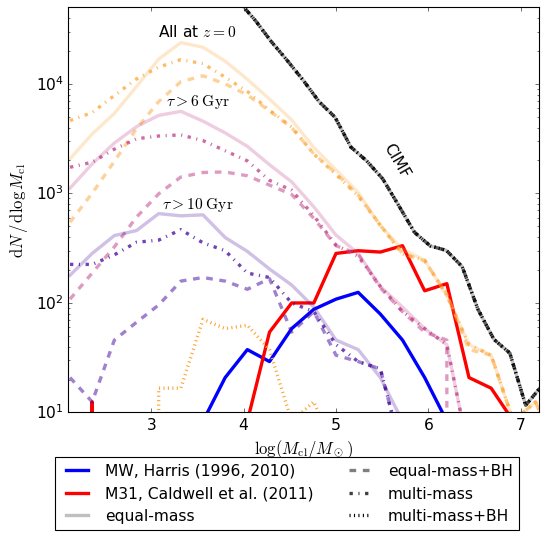

In [9]:
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
styles = ['solid', 'dashed', 'dashdot', 'dotted']
transparency = [0.25, 0.5, 0.75, 1.0]

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(7,7))

ax.plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW, Harris (1996, 2010)')
ax.plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31, Caldwell et al. (2011)')
ax.set_xlim(2.1,7.2)
ax.set_xlabel(r'$\log (M_{\mathrm{cl}} / M_\odot )$', fontsize=15)
ax.tick_params(labelsize=14)

for i, mf in enumerate(initial_population):
  ax.plot(imarray_plot, mf, c='k', linewidth=3, linestyle=styles[i], alpha=transparency[i], label=model[i])

for i, mf in enumerate(full_population):
  ax.plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle=styles[i], alpha=transparency[i])

for i, mf in enumerate(intermediate_population):
  ax.plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle=styles[i], alpha=transparency[i])
  
for i,mf in enumerate(old_population):
  ax.plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle=styles[i], alpha=transparency[i])

ax.text(5.65, 2e3, 'CIMF', ha='center', va='center', fontsize=14, rotation=-60)
ax.text(3.5, 3e4, r'All at $z=0$', ha='center', va='center', fontsize=14)
ax.text(3.5, 7e3, r'$\tau > 6 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)
ax.text(3.5, 8e2, r'$\tau > 10 \; \rm{Gyr}$', ha='center', va='center', fontsize=14)

ax.set(ylim=(1e1,5e4), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax.legend(loc='center', bbox_to_anchor=(0.465, -0.2), fontsize=14, ncols=2)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/fulltensor_mfs_paper.pdf')

# Current state of simulated GCMF

In [2]:
nbins = 25
min_gcmf = 1e2 # in solar masses
min_icmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)
marray_plot = 0.5 * (marray_gcmf[:-1] + marray_gcmf[1:])
imarray_plot = 0.5 * (marray_icmf[:-1] + marray_icmf[1:])

In [3]:
m31_masses = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

In [4]:
emosaics = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/emosaics_gcmf.csv', delimiter=',', skip_header=2)
emp2022 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/emp2022_gcmf.csv', delimiter=',', skip_header=2)
emp2023 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/emp2023_gcmf.csv', delimiter=',', skip_header=2)
gbf2023 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/gbf2023_gcmf.csv', delimiter=',', skip_header=2)
lignedin2019 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/lignedin2019_gcmf.csv', delimiter=',', skip_header=2)
twophase = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/TwoPhase_GCs.csv', delimiter=',')

In [5]:
emosaics_masses = emosaics[:,::2]
emosaics_counts = emosaics[:,1::2]

In [6]:
dn = np.zeros((marray_plot.size,10))
for i in range(10):
    for j in range(marray_plot.size):
        min_idx = np.nanargmin(np.abs(emosaics_masses[:,i] - marray_plot[j]))
        dn[j,i] = emosaics_counts[min_idx,i]

Text(0, 0.5, '$\\mathrm{d}N \\, / \\, \\mathrm{d} \\log M_{\\mathrm{cl}}$')

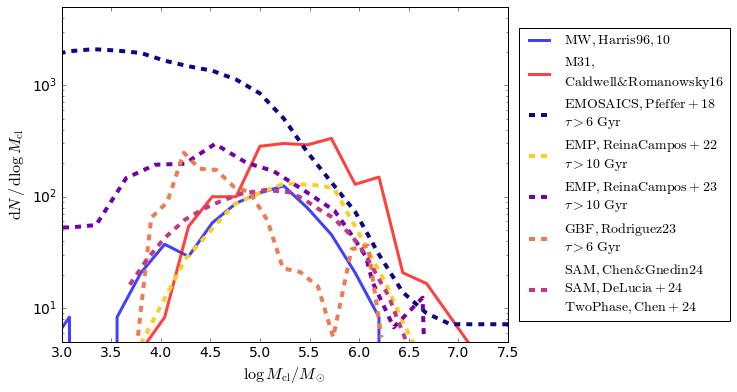

In [8]:
colors = plt.cm.plasma(np.linspace(0,0.9,5))
plt.figure(figsize=(8,6))
plt.plot(marray_plot, mw_mass_function, c='b', linewidth=3, alpha=0.75, label=r'$\rm{MW, Harris96, 10}$')
plt.plot(marray_plot, m31_mass_function, c='r', linewidth=3, alpha=0.75, label=r'$\rm{M31,}$'+'\n'+r'$\rm{Caldwell&Romanowsky16}$')
plt.plot(marray_plot, np.median(dn, axis=1), c=colors[0], linewidth=4, linestyle='--', label=r'$\rm{EMOSAICS, Pfeffer+18}$' +'\n' +r'$\tau > 6 \; \rm{Gyr}$')
plt.plot(np.log10(emp2022[:,0]), emp2022[:,1], c=colors[4], linewidth=4, linestyle='--', label=r'$\rm{EMP, ReinaCampos+22}$' +'\n' +r'$\tau > 10 \; \rm{Gyr}$')
plt.plot(emp2023[:,0], emp2023[:,1], c=colors[1], linewidth=4, linestyle='--', label=r'$\rm{EMP, ReinaCampos+23}$' +'\n' +r'$\tau > 10 \; \rm{Gyr}$')
plt.plot(np.log10(gbf2023[:,0]), 8*gbf2023[:,1], c=colors[3], linewidth=4, linestyle='--', label=r'$\rm{GBF, Rodriguez23}$' +'\n' +r'$\tau > 6 \; \rm{Gyr}$')
plt.plot(twophase[:,0]-.3, twophase[:,1], c=colors[2], linewidth=4, linestyle='--', label=r'$\rm{SAM, Chen&Gnedin24}$' +'\n' +r'$\rm{SAM, DeLucia+24}$' +'\n' +r'$\rm{TwoPhase, Chen+24}$')
plt.yscale('log')
plt.ylim(5e0, 5e3)
plt.xlim(3, 7.5)
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}/M_\odot$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)


Peak for MW GCMF log-normal fit: 5.07
Peak for M31 GCMF log-normal fit: 5.41


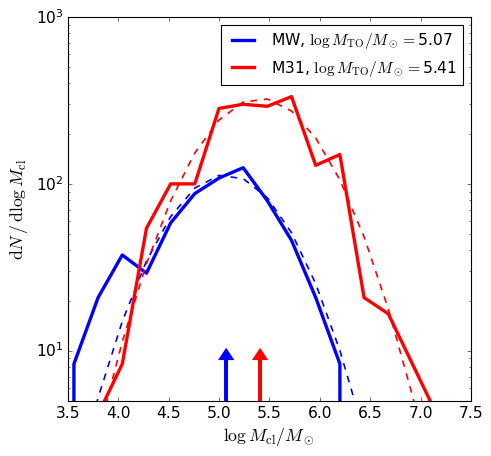

In [ ]:
# Fit the log-normal function to the data
poptmw, _ = curve_fit(log_normal, marray_plot, mw_mass_function, p0=[1e3, 5, 0.5])

# Extract the parameters
A, mu, sigma = poptmw
peakmw = mu  # The peak of the log-normal function

print(f"Peak for MW GCMF log-normal fit: {peakmw:.2f}")

# Plot the fit
plt.figure(figsize=(6.5, 6))
plt.plot(marray_plot, mw_mass_function, c='b', linewidth=3, label=r'MW, $\log M_{\rm{TO}}/M_\odot=$'+f'{peakmw:.2f}')
plt.plot(marray_plot, log_normal(marray_plot, *poptmw), c='b', linestyle='--', linewidth=1.5)
plt.arrow(peakmw, 5e0, 0, 5, color='b', linewidth=3, head_width=0.1, head_length=1, length_includes_head=True)

# Fit the log-normal function to the data
poptm31, _ = curve_fit(log_normal, marray_plot, m31_mass_function, p0=[1e3, 5, 0.5])

# Extract the parameters
A, mu, sigma = poptm31
peakm31 = mu  # The peak of the log-normal function

print(f"Peak for M31 GCMF log-normal fit: {peakm31:.2f}")

plt.plot(marray_plot, m31_mass_function, c='r', linewidth=3, label=r'M31, $\log M_{\rm{TO}}/M_\odot=$'+f'{peakm31:.2f}')
plt.plot(marray_plot, log_normal(marray_plot, *poptm31), c='r', linestyle='--', linewidth=1.5)
plt.arrow(peakm31, 5e0, 0, 5, color='r', linewidth=3, head_width=0.1, head_length=1, length_includes_head=True)

plt.yscale('log')
plt.xlabel(r'$\log M_{\mathrm{cl}}/M_\odot$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(3.5, 7.5)
plt.ylim(5e0, 1e3)
plt.show()